In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from scipy import sparse

from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [13]:
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

In [14]:
# Создаем Route, удаляем Origin и Dest
train1 = train.copy()
train1['Route'] = train1['Origin'] + '_' + train1['Dest']
train1.drop(columns=['Origin', 'Dest'], inplace=True)
train1.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,dep_delayed_15min,Route
0,c-8,c-21,c-7,1934,AA,732,N,ATL_DFW
1,c-4,c-20,c-3,1548,US,834,N,PIT_MCO
2,c-9,c-2,c-5,1422,XE,416,N,RDU_CLE
3,c-11,c-25,c-6,1015,OO,872,N,DEN_MEM
4,c-10,c-7,c-6,1828,WN,423,Y,MDW_OMA


In [15]:
test1 = test.copy()
test1['Route'] = test1['Origin'] + '_' + test1['Dest']
test1.drop(columns=['Origin', 'Dest'], inplace=True)
test1.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,Route
0,c-7,c-25,c-3,615,YV,598,MRY_PHX
1,c-4,c-17,c-2,739,WN,1235,LAS_HOU
2,c-12,c-2,c-7,651,MQ,577,GSP_ORD
3,c-3,c-25,c-7,1614,WN,377,BWI_MHT
4,c-6,c-6,c-3,1505,UA,258,ORD_STL


In [16]:
# Разделяем на X, y
X1 = train1.drop(columns='dep_delayed_15min')
y1 = train1['dep_delayed_15min'].map({'N':0, 'Y':1})
y1.unique()

array([0, 1])

In [17]:
# Выделяем кат. признаки
cat_cols1 = X1.select_dtypes(include='O').columns.values
cat_cols1

array(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Route'],
      dtype=object)

In [18]:
# Применяем OHE, объединяем с вещественными
ohe = OneHotEncoder(handle_unknown = 'ignore')
X1_cat = ohe.fit_transform(X1[cat_cols1])
X1_real = X1[list(set(X1.columns) - set(cat_cols1))].values
X1 = sparse.hstack((X1_cat, X1_real))
X1.shape

(100000, 4503)

In [19]:
test1_cat = ohe.transform(test1[cat_cols1])
test1_real = test1[list(set(test1.columns) - set(cat_cols1))].values
test1 = sparse.hstack((test1_cat, test1_real))
test1.shape

(100000, 4503)

In [20]:
# Разделение на обучение и валидацию
X1_train, X1_valid, y1_train, y1_valid = model_selection.train_test_split(X1, y1, test_size=0.2, random_state=0)

Логистическая регрессия

In [21]:
lr1 = LogisticRegressionCV(random_state=0, n_jobs=-1, scoring='roc_auc')
lr1.fit(X1_train, y1_train)

LogisticRegressionCV(n_jobs=-1, random_state=0, scoring='roc_auc')

In [22]:
lr1.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [23]:
roc_auc_score(y1_valid, lr1.predict_proba(X1_valid)[:, 1])

0.6990322220242813

Добавим стандартизацию данных

In [24]:
# Разделяем на X, y
X1_lr = train1.drop(columns='dep_delayed_15min')
y1_lr = train1['dep_delayed_15min'].map({'N':0, 'Y':1})

# Применяем OHE, объединяем с вещественными
scaler = StandardScaler()
X1_real_lr = scaler.fit_transform(X1_real)

X1_lr = sparse.hstack((X1_cat, X1_real_lr))

# Разделение на обучение и валидацию
X1_train_lr, X1_valid_lr, y1_train_lr, y1_valid_lr = model_selection.train_test_split(X1_lr, y1, test_size=0.2, random_state=0)

In [25]:
lr1_lr = LogisticRegressionCV(random_state=0, n_jobs=-1, scoring='roc_auc')
lr1_lr.fit(X1_train_lr, y1_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegressionCV(n_jobs=-1, random_state=0, scoring='roc_auc')

In [26]:
lr1.scores_[1].mean(axis=0)

array([0.68367517, 0.68891075, 0.69153148, 0.69194319, 0.69194295,
       0.6919431 , 0.69194295, 0.6919433 , 0.69194319, 0.69194328])

In [27]:
lr1.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [28]:
roc_auc_score(y1_valid, lr1_lr.predict_proba(X1_valid_lr)[:, 1])

0.7032674207143027

In [29]:
# Сначала обучим модель без подбора
dtrain = xgb.DMatrix(X1_train, y1_train)
dvalid = xgb.DMatrix(X1_valid, y1_valid)
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.1, "seed": 0}
# бинарная классификация, огранич. глубины дерева, убираем лишний вывод, шаг градиентного спуска
num_rounds = 50 # 50 итераций бустинга
xgb_model = xgb.train(params, dtrain, num_rounds)
preds_prob = xgb_model.predict(dvalid)

In [30]:
xgb_model.predict(dvalid).shape

(20000,)

In [31]:
roc_auc_score(y1_valid, preds_prob)

0.717843486152544

In [32]:
roc_auc_score(y1_valid, lr1.predict_proba(X1_valid)[:, 1])

0.6990322220242813

Гиперпараметры, которые отвечают за:
1. Сложность
2. Оптимизация

In [34]:
# Гиперпараметры, отвечающие за сложность модели
def score(params):
  print("Training with params:" , params)
  params["max_depth"] = int(params["max_depth"])
  dtrain = xgb.DMatrix(X1_train, label=y1_train)
  dvalid = xgb.DMatrix(X1_valid, label=y1_valid)
  model = xgb.train(params, dtrain, params["num_round"])
  predictions = model.predict(dvalid)#.reshape((X1_valid.shape[0], 2))
  score = -roc_auc_score(y1_valid, predictions) # Используется функция минимизации! Используем знак "-+"
  print("\tScore {0}\n".format(-score))
  return {"loss": score, "status": STATUS_OK}

In [35]:
def optimize(trials):
  space = {
      "num_round": 30, # фиксируем, берем немного
      "max_depth": hp.choice('max_depth', np.arange(1, 12, dtype=int)), # hp.quniform("max_depth", 1, 12, 1),
      "min_child_weight": hp.choice('min_child_weight', np.arange(1, 10, dtype=int)), # hp.quniform("min_child_weight", 1, 10, 1),
      "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
      "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
      "gamma": hp.uniform("gamma", low=0, high=1),
      "lambda": hp.uniform(label='lambda', low=0, high=1),
      "eval_metric": "auc",
      "objective": "binary:logistic",
      "silent": 1,
      "seed": hp.choice('seed', np.arange(5, dtype=int)) # "seed": hp.quniform("seed", 1, 5, 1),
    }

  best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20, show_progressbar=True)
  return best

In [ ]:
trials = Trials()
best_params = optimize(trials)

In [ ]:
best_params

In [38]:
best_params['num_round'] = 30
best_params['eval_metric'] = "auc"
best_params['objective'] = 'binary:logistic'
best_params['silent'] = 1
best_params['learning_rate'] = 0.003

dtrain = xgb.DMatrix(X1_train, y1_train)

In [39]:
# Гиперпараметры, отвечающие за оптимизацию

def optimize(trials):
  space = best_params.copy()
  space['learning_rate'] = hp.uniform("learning_rate", low=0.005, high=0.05)
  space['num_round'] = 500
  best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=5, show_progressbar=True)
  return best

best_lr = optimize(Trials())

Training with params:
{'colsample_bytree': 0.5, 'eval_metric': 'auc', 'gamma': 0.10502149346525858, 'lambda': 0.9204800763374689, 'learning_rate': 0.04009327751453941, 'max_depth': 10, 'min_child_weight': 3, 'num_round': 500, 'objective': 'binary:logistic', 'seed': 0, 'silent': 1, 'subsample': 0.9}
	Score 0.7448172603731904

Training with params:
{'colsample_bytree': 0.5, 'eval_metric': 'auc', 'gamma': 0.10502149346525858, 'lambda': 0.9204800763374689, 'learning_rate': 0.03244562732518279, 'max_depth': 10, 'min_child_weight': 3, 'num_round': 500, 'objective': 'binary:logistic', 'seed': 0, 'silent': 1, 'subsample': 0.9}
	Score 0.7449612641955279

Training with params:
{'colsample_bytree': 0.5, 'eval_metric': 'auc', 'gamma': 0.10502149346525858, 'lambda': 0.9204800763374689, 'learning_rate': 0.019498108936572948, 'max_depth': 10, 'min_child_weight': 3, 'num_round': 500, 'objective': 'binary:logistic', 'seed': 0, 'silent': 1, 'subsample': 0.9}
	Score 0.7447685216153798

Training with para

In [40]:
best_params['learning_rate'] = best_lr['learning_rate']
best_params

{'colsample_bytree': 0.5,
 'eval_metric': 'auc',
 'gamma': 0.10502149346525858,
 'lambda': 0.9204800763374689,
 'learning_rate': 0.0493371120087561,
 'max_depth': 10,
 'min_child_weight': 3,
 'num_round': 30,
 'objective': 'binary:logistic',
 'seed': 0,
 'silent': 1,
 'subsample': 0.9}

In [41]:
# Фиксируем learning_rate, строим до 2000 деревьев, выбираем лучшее значение
%%time
best_params.pop('num_round')
xgbCvResult = xgb.cv(best_params, dtrain, num_boost_round=2000, nfold=3, early_stopping_rounds=50)

CPU times: user 4min 28s, sys: 608 ms, total: 4min 29s
Wall time: 2min 19s


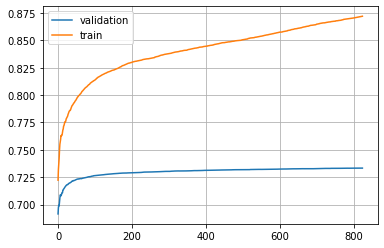

In [42]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-auc-mean"], label='validation')
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-auc-mean"], label='train')
plt.legend(); plt.grid();

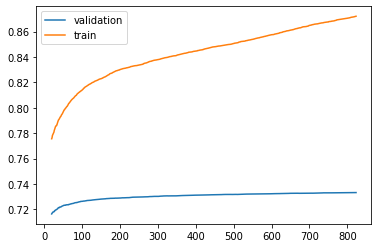

In [43]:
start_from = 20
plt.plot(range(start_from, xgbCvResult.shape[0]), xgbCvResult["test-auc-mean"][start_from:], label='validation')
plt.plot(range(start_from, xgbCvResult.shape[0]), xgbCvResult["train-auc-mean"][start_from:], label='train')
plt.legend();

In [45]:
%%time
best_xgb1 = xgb.train(best_params, dtrain, num_boost_round=best_num_round)
xgb1_predict_pr_valid = best_xgb1.predict(dvalid)

CPU times: user 1min 37s, sys: 179 ms, total: 1min 37s
Wall time: 58.8 s


In [46]:
roc_auc_score(y1_valid, xgb1_predict_pr_valid)

0.7467081280542056

In [47]:
dtest = xgb.DMatrix(test1)
xgboost1_predict_pr_test = best_xgb1.predict(dtest)

pd.Series(xgboost1_predict_pr_test, name="dep_delayed_15min").to_csv(
    "xgb1_stand_algo.csv", index_label="id", header=True)